In [16]:
import pandas as pd
import numpy as np
import re
import os
import json
import textstat
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt
import spacy
import string
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Concatenate, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score



nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/ddonu./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddonu./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train_easy_dir = 'pan24-multi-author-analysis/easy/train'
validation_easy_dir = 'pan24-multi-author-analysis/easy/validation'

train_medium_dir = 'pan24-multi-author-analysis/medium/train'
validation_medium_dir = 'pan24-multi-author-analysis/medium/validation'

train_hard_dir = 'pan24-multi-author-analysis/hard/train'
validation_hard_dir = 'pan24-multi-author-analysis/hard/validation'


In [2]:
def load_data(folder_path):
    text_files = [f for f in os.listdir(folder_path) if f.startswith('problem') and f.endswith('.txt')]
    rows = []

    for text_file in text_files:
        text_file_path = os.path.join(folder_path, text_file)
        label_file_path = text_file_path.replace('.txt', '.json').replace('problem', 'truth-problem')

        with open(text_file_path, 'r', encoding="utf8") as file:
            paragraphs = file.read().split('\n')

        with open(label_file_path, 'r', encoding="utf8") as file:
            labels = json.load(file)['changes']

        for i in range(len(labels)):
            para1 = paragraphs[i]
            para2 = paragraphs[i+1]
            label = labels[i]
            rows.append({'Para1': para1, 'Para2': para2, 'Label': label})

    return pd.DataFrame(rows)


folder_path = 'pan24-multi-author-analysis/medium/train'
df = load_data(folder_path)

In [3]:
df_validation = load_data('pan24-multi-author-analysis/medium/validation')

In [4]:
#N-gram
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
features_p1 = vectorizer.fit_transform(df['Para1']).toarray()
features_p2 = vectorizer.transform(df['Para2']).toarray()
ngram_features = np.abs(features_p1 - features_p2)

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
tfidf_p1 = tfidf.fit_transform(df['Para1']).toarray()
tfidf_p2 = tfidf.transform(df['Para2']).toarray()
tfidf_features = np.abs(tfidf_p1 - tfidf_p2)


In [58]:

print(f"ngram_features min value: {ngram_features.min()}, max value: {ngram_features.max()}")
print(f"Dependency features dtype: {ngram_features.dtype}")

print(f"tfidf_features min value: {tfidf_features.min()}, max value: {tfidf_features.max()}")
print(f"tfidf_features dtype: {tfidf_features.dtype}")

ngram_features min value: 0, max value: 32
Dependency features dtype: int64
tfidf_features min value: 0.0, max value: 0.9475430969975801
tfidf_features dtype: float64


In [5]:
# Sequence
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Para1'].tolist() + df['Para2'].tolist())


sequences_p1 = tokenizer.texts_to_sequences(df['Para1'])
sequences_p2 = tokenizer.texts_to_sequences(df['Para2'])


max_length = max(max([len(seq) for seq in sequences_p1]), max([len(seq) for seq in sequences_p2]))
p1_padded = pad_sequences(sequences_p1, maxlen=max_length, padding='post', truncating='post')
p2_padded = pad_sequences(sequences_p2, maxlen=max_length, padding='post', truncating='post')


sequence_features = np.abs(p1_padded - p2_padded)
assert sequence_features.shape[0] == len(df)

In [61]:
print(f"sequence_features min value: {sequence_features.min()}, max value: {sequence_features.max()}")
print(f"sequence_features dtype: {sequence_features.dtype}")

max_index = 50000  
if p1_padded.max() >= max_index or p2_padded.max() >= max_index:
    print("Warning: Some indices are out of the vocabulary range")
else:
    print("All indices are within the vocabulary range")


sequence_features min value: 0, max value: 9999
sequence_features dtype: int32
All indices are within the vocabulary range


In [6]:
# Stylometric features
def get_stylistic_features(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    
    avg_sentence_length = np.mean([len(sentence.split()) for sentence in sentences])
    avg_word_length = np.mean([len(word) for word in words])
    type_token_ratio = len(set(words)) / len(words)
    hashtag_count = text.count('#')
    punctuation_count = sum([1 for char in text if char in string.punctuation])
    repeated_errors = sum([text.count(word) > 1 for word in words])
    
    
    readability = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    shannon_entropy = -sum([(words.count(word) / len(words)) * np.log2(words.count(word) / len(words)) for word in set(words)])
    
    
    complex_sentence_ratio = sum([1 for sentence in sentences if ',' in sentence]) / len(sentences)
    simple_sentence_ratio = 1 - complex_sentence_ratio
    
    
    metaphor_count = text.lower().count('like')  
    repetition_count = sum([1 for word in set(words) if words.count(word) > 1])
    
    return [avg_sentence_length, avg_word_length, type_token_ratio, hashtag_count, punctuation_count, repeated_errors,
            readability, gunning_fog, shannon_entropy, complex_sentence_ratio, simple_sentence_ratio, metaphor_count, repetition_count]

stylistic_features_p1 = df['Para1'].apply(get_stylistic_features)
stylistic_features_p2 = df['Para2'].apply(get_stylistic_features)

stylistic_features_p1 = np.array(stylistic_features_p1.tolist())
stylistic_features_p2 = np.array(stylistic_features_p2.tolist())

stylistic_features = np.abs(stylistic_features_p1 - stylistic_features_p2)


In [7]:

#syntactic_semantic_features
tokenizer = Tokenizer()

def get_syntactic_semantic_features(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    pos_counts = Counter([tag for word, tag in pos_tags])
    
    
    noun_count = pos_counts.get('NN', 0) + pos_counts.get('NNS', 0) + pos_counts.get('NNP', 0) + pos_counts.get('NNPS', 0)
    verb_count = sum(pos_counts.get(tag, 0) for tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    adj_count = sum(pos_counts.get(tag, 0) for tag in ['JJ', 'JJR', 'JJS'])
    adv_count = sum(pos_counts.get(tag, 0) for tag in ['RB', 'RBR', 'RBS'])
    
    
    svo_ratio = sum(1 for word, tag in pos_tags if tag.startswith('VB')) / len(pos_tags) if len(pos_tags) > 0 else 0
    noun_clause_ratio = text.lower().count('that') / len(sentences) if len(sentences) > 0 else 0
    adj_clause_ratio = text.lower().count('which') / len(sentences) if len(sentences) > 0 else 0
    adv_clause_ratio = text.lower().count('because') / len(sentences) if len(sentences) > 0 else 0
    
    
    tokenizer.fit_on_texts([text])
    word_indices = [tokenizer.word_index[word] for word in words if word in tokenizer.word_index]
    word_embeddings = np.mean(word_indices) if word_indices else 0
    
    tfidf_vectorizer = TfidfVectorizer()
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform([text])
        tfidf_mean = np.mean(tfidf_matrix.toarray())
    except ValueError:
        tfidf_mean = 0  
    
    
    features = [
        noun_count, verb_count, adj_count, adv_count,
        svo_ratio, noun_clause_ratio, adj_clause_ratio, adv_clause_ratio,
        word_embeddings, tfidf_mean
    ]
    
    return features

syntactic_semantic_features_p1 = df['Para1'].apply(get_syntactic_semantic_features)
syntactic_semantic_features_p2 = df['Para2'].apply(get_syntactic_semantic_features)

syntactic_semantic_features_p1 = np.array(syntactic_semantic_features_p1.tolist())
syntactic_semantic_features_p2 = np.array(syntactic_semantic_features_p2.tolist())

syntactic_semantic_features = np.abs(syntactic_semantic_features_p1 - syntactic_semantic_features_p2)

In [8]:
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer()

In [9]:
def get_pos_tags(text):
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    total_tokens = len(doc)
    pos_ratios = {pos: count / total_tokens for pos, count in pos_counts.items()}
    return pos_ratios

pos_tags_p1 = df['Para1'].apply(get_pos_tags)
pos_tags_p2 = df['Para2'].apply(get_pos_tags)

pos_tags_p1 = pos_tags_p1.apply(lambda x: [x.get(pos, 0) for pos in nlp.get_pipe("tagger").labels])
pos_tags_p2 = pos_tags_p2.apply(lambda x: [x.get(pos, 0) for pos in nlp.get_pipe("tagger").labels])

pos_tags_p1 = np.array(pos_tags_p1.tolist())
pos_tags_p2 = np.array(pos_tags_p2.tolist())

pos_features = np.abs(pos_tags_p1 - pos_tags_p2)

In [10]:
# constituent structure
def get_constituent_structure(text):
    doc = nlp(text)
    sentence_lengths = [len(sent) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0
    return len(list(doc.sents)), avg_sentence_length

constituent_structure_p1 = df['Para1'].apply(get_constituent_structure)
constituent_structure_p2 = df['Para2'].apply(get_constituent_structure)

constituent_structure_features = np.abs(np.array(constituent_structure_p1.tolist()) - np.array(constituent_structure_p2.tolist()))


In [11]:
# dependency structure
def get_dependency_structure(text):
    doc = nlp(text)
    dependencies = [token.dep_ for token in doc]
    depth_sum = sum([token.dep for token in doc if token.head != token])
    avg_depth = depth_sum / len(dependencies) if dependencies else 0
    dep_counts = Counter(dependencies)
    return dep_counts, avg_depth

dependency_structure_p1 = df['Para1'].apply(get_dependency_structure)
dependency_structure_p2 = df['Para2'].apply(get_dependency_structure)

dependency_counts_p1 = dependency_structure_p1.apply(lambda x: x[0])
dependency_counts_p2 = dependency_structure_p2.apply(lambda x: x[0])

dependency_counts_p1 = dependency_counts_p1.apply(lambda x: [x.get(dep, 0) for dep in nlp.get_pipe("parser").labels])
dependency_counts_p2 = dependency_counts_p2.apply(lambda x: [x.get(dep, 0) for dep in nlp.get_pipe("parser").labels])

dependency_counts_p1 = np.array(dependency_counts_p1.tolist())
dependency_counts_p2 = np.array(dependency_counts_p2.tolist())

dependency_avg_depth_p1 = np.array(dependency_structure_p1.apply(lambda x: x[1]).tolist())
dependency_avg_depth_p2 = np.array(dependency_structure_p2.apply(lambda x: x[1]).tolist())

dependency_features = np.abs(dependency_counts_p1 - dependency_counts_p2)
dependency_depth_features = np.abs(dependency_avg_depth_p1 - dependency_avg_depth_p2).reshape(-1, 1)


In [12]:
# LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda_p1 = lda.fit_transform(tfidf_p1)
lda_p2 = lda.transform(tfidf_p2)
lda_features = np.abs(lda_p1 - lda_p2)

# sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

sentiment_p1 = df['Para1'].apply(get_sentiment)
sentiment_p2 = df['Para2'].apply(get_sentiment)
sentiment_features = np.abs(sentiment_p1 - sentiment_p2).values.reshape(-1, 1)


In [13]:
# Structural features
def get_structural_features(text):
    punctuation_count = sum([1 for char in text if char in string.punctuation])
    paragraph_length = len(text.split())
    sentences = sent_tokenize(text)
    avg_sentence_length = np.mean([len(sentence.split()) for sentence in sentences])
    complex_sentence_ratio = sum([1 for sentence in sentences if ',' in sentence]) / len(sentences)
    
    return [punctuation_count, paragraph_length, len(sentences), avg_sentence_length, complex_sentence_ratio]

structural_features_p1 = df['Para1'].apply(get_structural_features)
structural_features_p2 = df['Para2'].apply(get_structural_features)

structural_features_p1 = np.array(structural_features_p1.tolist())
structural_features_p2 = np.array(structural_features_p2.tolist())

structural_features = np.abs(structural_features_p1 - structural_features_p2)


In [14]:
# all featurs 
non_sequence_features = np.hstack([
    ngram_features,
    tfidf_features,
    stylistic_features,
    syntactic_semantic_features,
    structural_features,
    pos_features,
    constituent_structure_features,
    dependency_features,
    dependency_depth_features,
    lda_features,
    sentiment_features
])


scaler = StandardScaler()
non_sequence_features = scaler.fit_transform(non_sequence_features)




In [35]:
# 模型参数
embedding_dim = 128
input_dim = 10000  # 与Tokenizer中num_words一致
output_dim = embedding_dim

# 准备交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 保存每次验证的结果
histories = []

# 交叉验证
for train_index, val_index in kf.split(p1_padded):
    X_train_seq_p1, X_val_seq_p1 = p1_padded[train_index], p1_padded[val_index]
    X_train_seq_p2, X_val_seq_p2 = p2_padded[train_index], p2_padded[val_index]
    X_train_non_seq, X_val_non_seq = non_sequence_features[train_index], non_sequence_features[val_index]
    y_train, y_val = df['Label'].values[train_index], df['Label'].values[val_index]
    
    # 模型构建
    input_p1 = Input(shape=(max_length,))
    input_p2 = Input(shape=(max_length,))
    input_non_seq = Input(shape=(non_sequence_features.shape[1],))

    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)
    embedded_p1 = embedding_layer(input_p1)
    embedded_p2 = embedding_layer(input_p2)

    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))
    lstm_p1 = lstm_layer(embedded_p1)
    lstm_p2 = lstm_layer(embedded_p2)

    lstm_p1_flat = Flatten()(lstm_p1)
    lstm_p2_flat = Flatten()(lstm_p2)

    merged_seq = Concatenate()([lstm_p1_flat, lstm_p2_flat])
    merged_all = Concatenate()([merged_seq, input_non_seq])

    merged = Dense(64, activation='relu')(merged_all)
    merged = Dropout(0.5)(merged)
    output = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[input_p1, input_p2, input_non_seq], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        [X_train_seq_p1, X_train_seq_p2, X_train_non_seq], y_train,
        epochs=50,
        batch_size=64,
        validation_data=([X_val_seq_p1, X_val_seq_p2, X_val_non_seq], y_val),
        callbacks=[early_stopping]
    )
    
    histories.append(history.history)

# 绘制训练和验证的损失和准确率曲线
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

for i, history in enumerate(histories):
    ax1.plot(history['loss'], label=f'Train Fold {i+1}')
    ax1.plot(history['val_loss'], label=f'Val Fold {i+1}', linestyle='--')
    ax2.plot(history['accuracy'], label=f'Train Fold {i+1}')
    ax2.plot(history['val_accuracy'], label=f'Val Fold {i+1}', linestyle='--')

ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

Epoch 1/50
274/274 [==============================] - 158s 571ms/step - loss: 0.4927 - accuracy: 0.7019 - val_loss: 0.4482 - val_accuracy: 0.7274
Epoch 2/50
274/274 [==============================] - 172s 628ms/step - loss: 0.4181 - accuracy: 0.7634 - val_loss: 0.4504 - val_accuracy: 0.7319
Epoch 3/50
274/274 [==============================] - 332s 1s/step - loss: 0.2862 - accuracy: 0.8697 - val_loss: 0.5436 - val_accuracy: 0.7253
Epoch 4/50
274/274 [==============================] - 430s 2s/step - loss: 0.1265 - accuracy: 0.9533 - val_loss: 0.8341 - val_accuracy: 0.7271
Epoch 1/50
274/274 [==============================] - 462s 2s/step - loss: 0.5012 - accuracy: 0.6969 - val_loss: 0.4383 - val_accuracy: 0.7379
Epoch 2/50
274/274 [==============================] - 423s 2s/step - loss: 0.4189 - accuracy: 0.7649 - val_loss: 0.4276 - val_accuracy: 0.7502
Epoch 3/50
274/274 [==============================] - 433s 2s/step - loss: 0.2785 - accuracy: 0.8756 - val_loss: 0.5560 - val_accuracy: 

NameError: name 'plt' is not defined

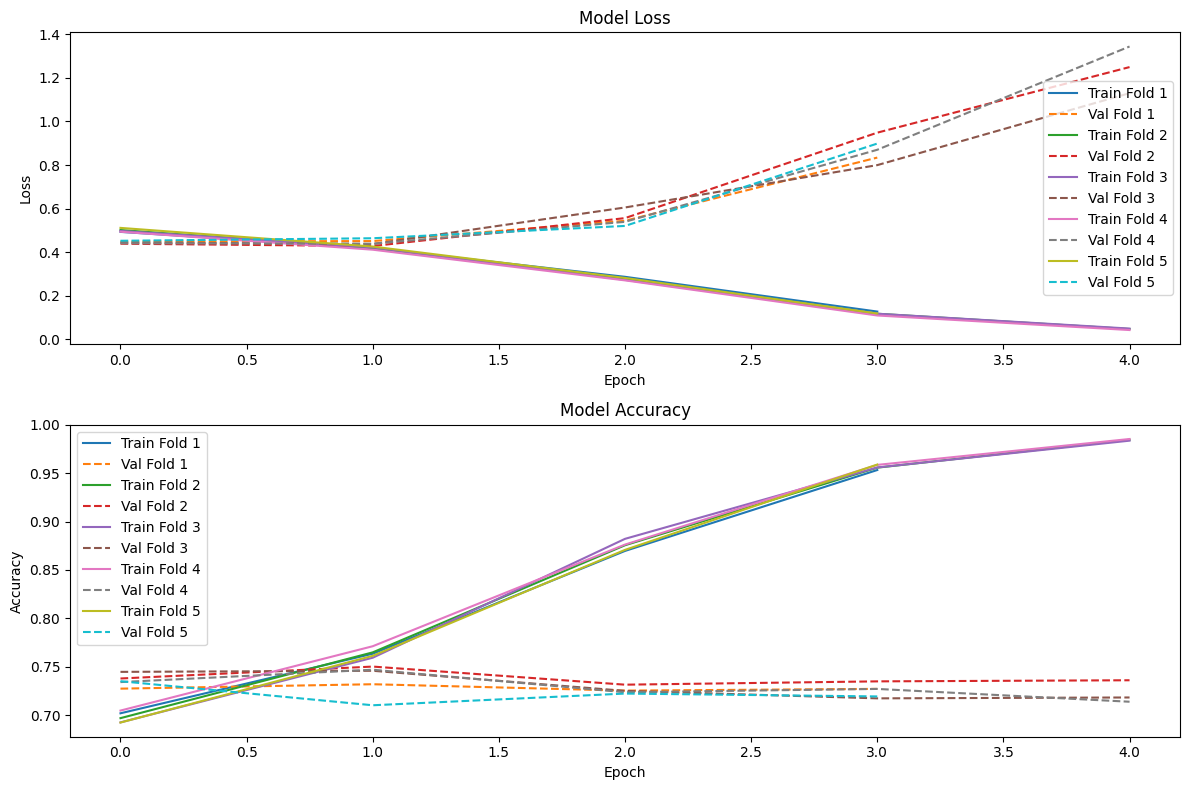

In [38]:
# 绘制训练和验证的损失和准确率曲线
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

for i, history in enumerate(histories):
    ax1.plot(history['loss'], label=f'Train Fold {i+1}')
    ax1.plot(history['val_loss'], label=f'Val Fold {i+1}', linestyle='--')
    ax2.plot(history['accuracy'], label=f'Train Fold {i+1}')
    ax2.plot(history['val_accuracy'], label=f'Val Fold {i+1}', linestyle='--')

ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_83557/3615335037.py:33: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-y_val * np.log(y_pred_proba) - (1 - y_val) * np.log(1 - y_pred_proba))
/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_83557/3615335037.py:33: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean(-y_val * np.log(y_pred_proba) - (1 - y_val) * np.log(1 - y_pred_proba))
/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_83557/3615335037.py:33: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-y_val * np.log(y_pred_proba) - (1 - y_val) * np.log(1 - y_pred_proba))
/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_83557/3615335037.py:33: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean(-y_val * np.log(y_pred_proba) - (1 - y_val) * np.log(1 - y_pred_proba))
/var/folders/dt/n8b1m5p109l2bwl3ygbxq3qw0000gn/T/ipykernel_83557/3615335037.py:33: RuntimeWarning: divid

Fold 1 - Loss: 0.4384392847222669, Accuracy: 0.7588409765001141, Precision: 0.7234108527131783, Recall: 0.933947157726181, F1-score: 0.815306657347545, ROC-AUC: 0.8642910084035398
Fold 2 - Loss: 0.42999450225930735, Accuracy: 0.7627195984485512, Precision: 0.7303020865773903, Recall: 0.9309249702262803, F1-score: 0.818499127399651, ROC-AUC: 0.8668086065217651
Fold 3 - Loss: nan, Accuracy: 0.7681953000228154, Precision: 0.7321991178323881, Recall: 0.9333333333333333, F1-score: 0.8206214689265536, ROC-AUC: 0.8693430881476247
Fold 4 - Loss: nan, Accuracy: 0.761296211775445, Precision: 0.7233176838810642, Recall: 0.9344925192074404, F1-score: 0.81545518701482, ROC-AUC: 0.8654054675778662
Fold 5 - Loss: nan, Accuracy: 0.7350524874486536, Precision: 0.7103298070939639, Recall: 0.9084759251890171, F1-score: 0.7972760607647984, ROC-AUC: 0.8337659685951937

Average Scores:
Loss: nan
Accuracy: 0.7572209148391158
Precision: 0.723911909619597
Recall: 0.9282347811364504
F1: 0.8134317002906736
Roc_a

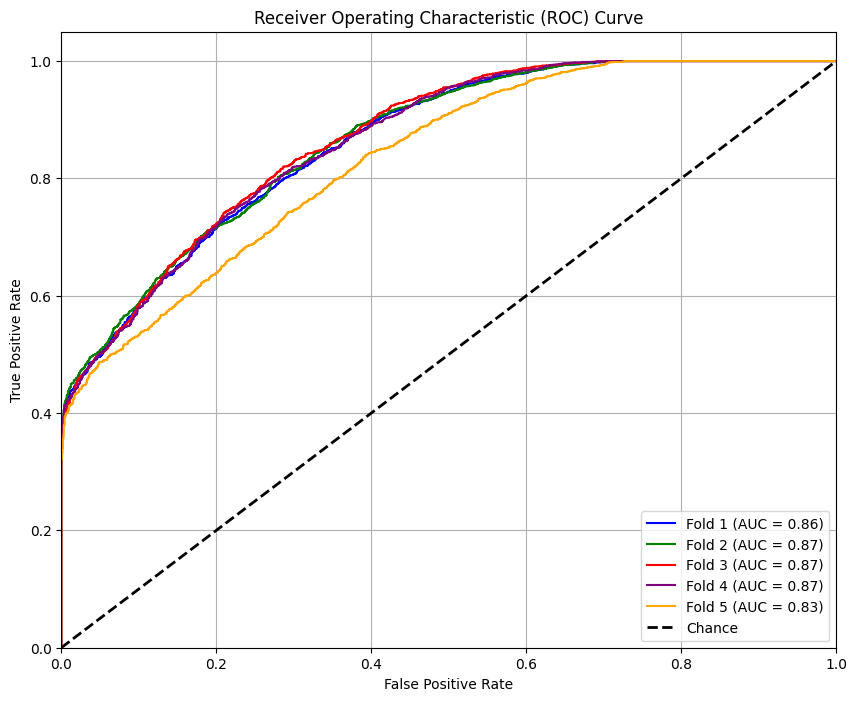

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# 假设 histories 已经保存了之前训练的历史数据
# val_predictions 存储每个交叉验证折的验证集预测结果
val_predictions = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(kf.split(p1_padded)):
    X_val_seq_p1 = p1_padded[val_index]
    X_val_seq_p2 = p2_padded[val_index]
    X_val_non_seq = non_sequence_features[val_index]
    y_val = df['Label'].values[val_index]
    
    # 假设保存了验证集的预测概率
    y_pred_proba = model.predict([X_val_seq_p1, X_val_seq_p2, X_val_non_seq], verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    val_predictions.append((y_val, y_pred, y_pred_proba))

# 计算各项评估指标
val_scores = {
    'loss': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

for i, (y_val, y_pred, y_pred_proba) in enumerate(val_predictions):
    loss = np.mean(-y_val * np.log(y_pred_proba) - (1 - y_val) * np.log(1 - y_pred_proba))
    accuracy = np.mean(y_val == y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    val_scores['loss'].append(loss)
    val_scores['accuracy'].append(accuracy)
    val_scores['precision'].append(precision)
    val_scores['recall'].append(recall)
    val_scores['f1'].append(f1)
    val_scores['roc_auc'].append(roc_auc)

# 打印每个交叉验证折的评估得分
for i in range(len(val_predictions)):
    print(f"Fold {i+1} - Loss: {val_scores['loss'][i]}, Accuracy: {val_scores['accuracy'][i]}, "
          f"Precision: {val_scores['precision'][i]}, Recall: {val_scores['recall'][i]}, "
          f"F1-score: {val_scores['f1'][i]}, ROC-AUC: {val_scores['roc_auc'][i]}")

# 计算和打印平均评估得分
mean_scores = {metric: np.mean(values) for metric, values in val_scores.items()}
print("\nAverage Scores:")
for metric, score in mean_scores.items():
    print(f"{metric.capitalize()}: {score}")

# 绘制ROC曲线
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple', 'orange']  # 颜色列表

for i, (y_val, y_pred_proba) in enumerate([(val[0], val[2]) for val in val_predictions]):
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.plot(fpr, tpr, color=colors[i], label=f'Fold {i+1} (AUC = {val_scores["roc_auc"][i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


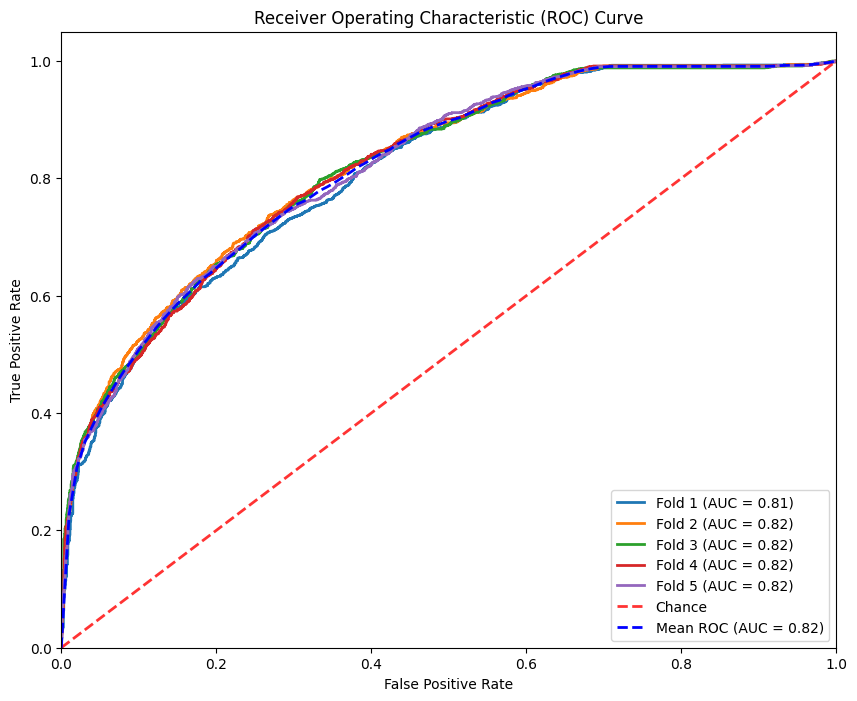

Baseline Model (Logistic Regression) Average Scores:
Accuracy: 0.7285629534979237
Precision: 0.7579411996531883
Recall: 0.7697110381813815
F1: 0.7637807783955519
ROC-AUC: 0.819824774910043


In [17]:
# 准备交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 初始化逻辑回归模型
model = LogisticRegression(max_iter=1000)

# 初始化保存结果的变量
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for i, (train_index, test_index) in enumerate(kf.split(non_sequence_features)):
    X_train, X_test = non_sequence_features[train_index], non_sequence_features[test_index]
    y_train, y_test = df['Label'][train_index], df['Label'][test_index]
    
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 计算ROC曲线
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# 绘制对角线
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# 平均ROC曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(df['Label'], cross_val_predict(model, non_sequence_features, df['Label'], cv=kf, method='predict_proba')[:, 1])
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')

# 图形设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 计算并打印评估指标
y_pred = cross_val_predict(model, non_sequence_features, df['Label'], cv=kf, method='predict')
y_pred_proba = cross_val_predict(model, non_sequence_features, df['Label'], cv=kf, method='predict_proba')[:, 1]

accuracy = accuracy_score(df['Label'], y_pred)
precision = precision_score(df['Label'], y_pred)
recall = recall_score(df['Label'], y_pred)
f1 = f1_score(df['Label'], y_pred)
roc_auc = roc_auc_score(df['Label'], y_pred_proba)

print(f"Baseline Model (Logistic Regression) Average Scores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"ROC-AUC: {roc_auc}")
